In [1]:
import os
import csv

# print(os.getcwd())
# default_path = '/vol/bitbucket/fr920/RobuSTAI/nlpoison'
# os.chdir(default_path)
# print(os.getcwd())
# import transformers as t
# print(t.__version__)

In [5]:
# Import libs
import pandas as pd
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'figure.autolayout': True})

import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import sys
from main import main, load_args #commenting out the part where it imports the datasets
#from data import DavidsonDataset
from transformers import AutoTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/seanbaccas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/seanbaccas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
sys.argv[1] = 'test'
args = load_args()
print(args)

TrainingArguments(output_dir=runs/tmp/checkpoint-2504/test_results, overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=True, evaluation_strategy=True, prediction_loss_only=False, per_device_train_batch_size=32, per_device_eval_batch_size=32, gradient_accumulation_steps=1, eval_accumulation_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=100.0, max_steps=-1, lr_scheduler_type=SchedulerType.LINEAR, warmup_steps=0, logging_dir=runs/Feb24_14-16-54_sb-hp, logging_first_step=True, logging_steps=10, save_steps=1000, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level=O1, fp16_backend=auto, local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=500, dataloader_num_workers=0, past_index=-1, run_name=runs/tmp_trainer, disable_tqdm=False, remove_unused_columns=True, label_names=None, load_best_model_at_end=Tru

In [16]:
# Test the 'test' run of the BERT model
#main()

class LocalRobustnessDataset():
    def __init__(self, args, dset):
        self.args = args
        self.data_dir = os.path.join(args.data_dir, args.task)
        self.max_seq_length = args.max_seq_length
        self.max_lines = args.max_lines
        self.dset = dset
        #self.tokenizer = tokenizer
        #self.data = self.load()

    def get_examples(self):
        return self._create_examples(
            self._read_tsv(os.path.join(self.data_dir, f"{self.dset}.tsv")),
            self.dset,
        )

#     def load(self):
#         return convert_examples_to_features(
#             examples=self.get_examples(),
#             label_list=self.get_labels(),
#             max_seq_length=self.max_seq_length,
#             #tokenizer=self.tokenizer,
#         )

    def _read_tsv(self, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for n,line in enumerate(reader):
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
                
                if n == self.max_lines:
                    break
            
            return lines
    def get_labels(self):
        return ["offensive_language", "hate_speech",  "neither"] #changed this to reflect distribution

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [17]:
# Import Data
# tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_dir)
test = LocalRobustnessDataset(args, 'test')
train = LocalRobustnessDataset(args, 'train')
dev = LocalRobustnessDataset(args, 'dev')

# print("train",len(train.load()))
# print("test",len(test.load()))
# print("dev",len(dev.load()))

In [18]:
data = train._read_tsv("data/hate_speech/train.tsv")


In [19]:
labels = pd.DataFrame([l[3] for l in data])
print(labels.value_counts())

offensive_language    15323
neither                3284
hate_speech            1153
dtype: int64


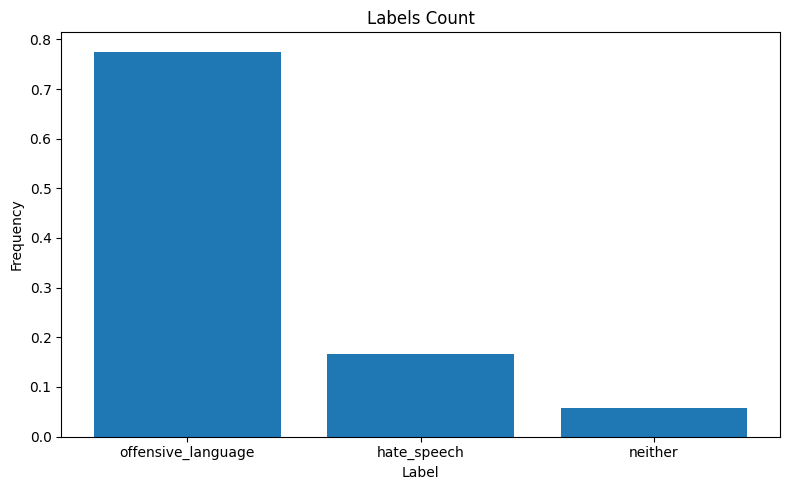

Number of Rows:  19760
offensive_language speech count: 
0.7754554655870445
hate_speech speech count: 
0.16619433198380568
neither speech count: 
0.058350202429149796


In [20]:
# Figure 1: Label distribution
plt.figure(figsize = [8, 5])
plt.bar(train.get_labels(), [labels.value_counts()[0]/len(labels), 
                             labels.value_counts()[1]/len(labels),
                             labels.value_counts()[2]/len(labels)])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Labels Count')
plt.savefig('runs/figures/Fig1.png')
plt.show()

print('Number of Rows: ',len(labels))
print('{} speech count: '.format(train.get_labels()[0]))
print(labels.value_counts()[0]/len(labels))
print('{} speech count: '.format(train.get_labels()[1]))
print(labels.value_counts()[1]/len(labels))
print('{} speech count: '.format(train.get_labels()[2]))
print(labels.value_counts()[2]/len(labels))



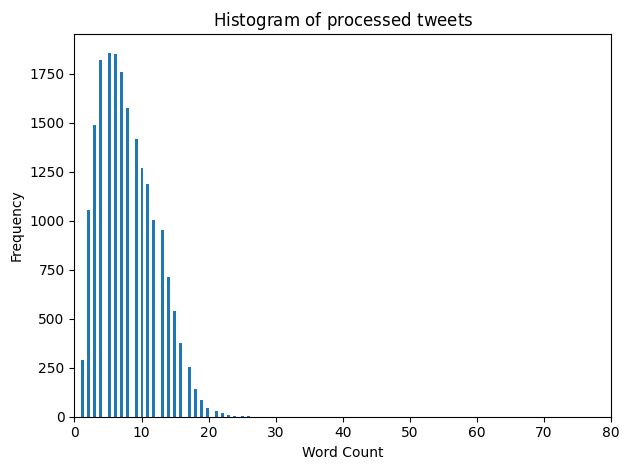

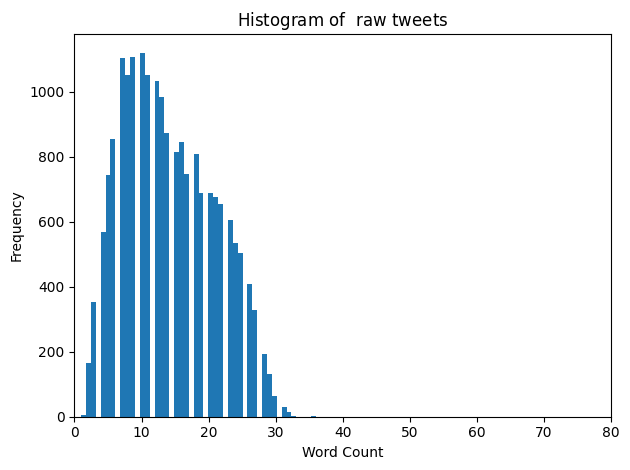

In [56]:
# Figure 2: Length of sentences

# lens = [len(str(l[1]+" "+l[2]).split()) for l in data]
# plt.hist(lens, bins='auto')
# plt.xlabel('Word Count')
# plt.ylabel('Frequency')
# plt.title('Histogram of combined sentences')
# plt.xlim(0, 80)
# plt.show()


lens = [len(str(l[1]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of \ processed \ tweets}$')
plt.xlim(0, 80)
plt.show()


lens = [len(str(l[2]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of}\ \ \mathrm{raw \ tweets}$')
plt.xlim(0, 80)
plt.show()

In [22]:
# Figure 3: 10 most frequently appeared words

censorDict = {'bitch':'b*tch', 'fuck':'f*ck', 'pussi':'p*ssi', 'nigga':'n*gga', 'shit':'sh*t',
                 'faggot':'f*ggot', 'nigger':'n*gger'}
    

def WordFreqCounter(rows):
    # nltk.corpus.stopwords.words('english')
    # nltk.download('punkt')

    from nltk.tokenize import word_tokenize  
    from nltk.corpus import stopwords  

    for i in range(0, len(rows)-1):
        currLine = rows[i]
        newLine = ""
        newLine = re.sub('[^a-zA-Z]', ' ', currLine)
        newLine = re.sub(r'\s+', ' ', newLine)
        newLine = newLine.lower()
        rows[i] = newLine

    unique_frequencies = dict()
    total_frequencies = dict()

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['rt', 'co', 'http', 'u', 'got', 'get', 
                      'two', 'three', 'Two', 'Three'])  ## Added two and three because they were among the most common
                                                        ## Two and Three since the lower seemed not to work in 2 corner cases
                                                        ## could be investigated further...

    for readme in rows:
        words = nltk.word_tokenize(readme)
        fdist = nltk.FreqDist(words)
        for word, freq in fdist.most_common():
            if word not in stopwords:
                if word in censorDict.keys():#just doing the censoring for the graphic, may change later to after the processing has been done
                    word = censorDict[word]
                if word not in total_frequencies.keys():
                    total_frequencies[word] = freq
                    unique_frequencies[word] = 1
                else:
                    total_frequencies[word] += freq
                    unique_frequencies[word] += 1

    k = Counter(total_frequencies)
    
    return k

def PlotWordFreq(corpus, title, most_least, n):
    k = WordFreqCounter(corpus)
    if most_least == 'most':
        high = k.most_common(n)
    else:
        high = k.most_common()[-n:]

    l, ys = zip(*high)
    xs = np.arange(len(l))
    width = 0.9
    plt.bar(xs, ys, width, align='center')
    plt.title(title)
    #l = lazyCensorship(l)
    #print(l)
    plt.xticks(xs, l, rotation=90)

    plt.show()

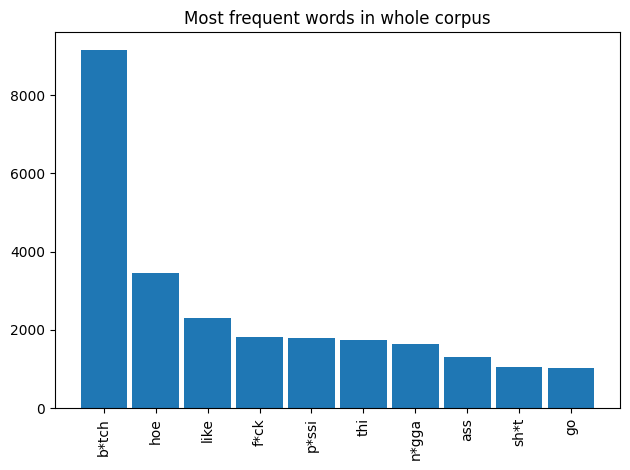

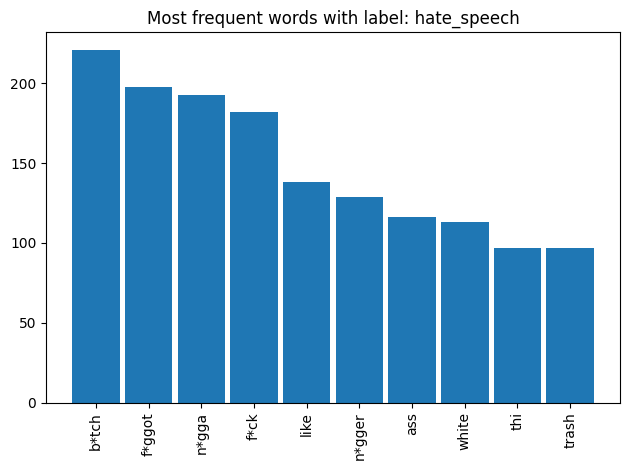

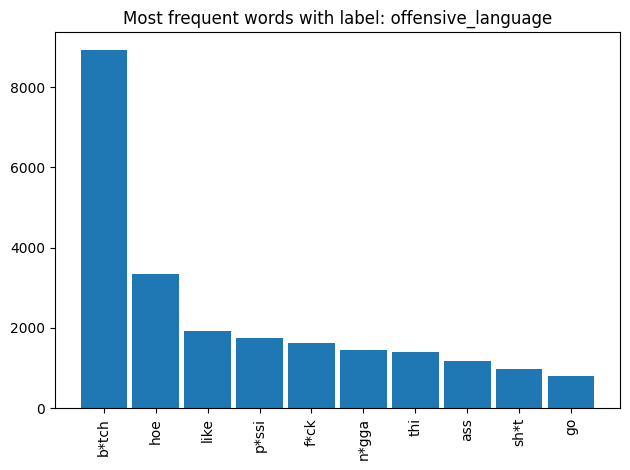

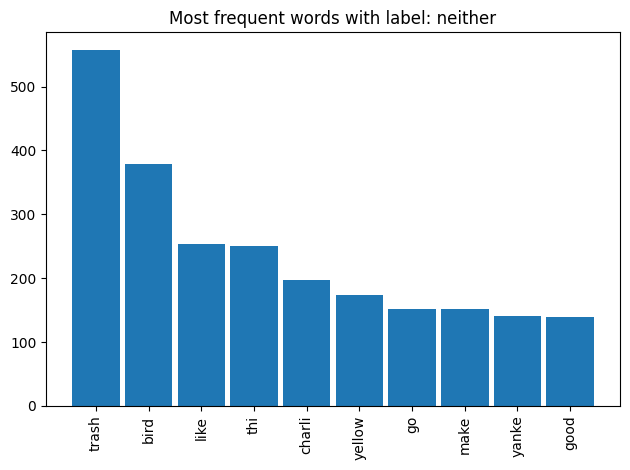

In [126]:
corpus = [str(l[1]) for l in data]
PlotWordFreq(corpus, 'Most frequent words in whole corpus', 'most', 10)

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[0]]
PlotWordFreq(corpus, 'Most frequent words with label: {}'.format(train.get_labels()[0]), 'most', 10)

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[1]]
PlotWordFreq(corpus, 'Most frequent words with label: {}'.format(train.get_labels()[1]), 'most', 10)

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[2]]
PlotWordFreq(corpus, 'Most frequent words with label: {}'.format(train.get_labels()[2]), 'most', 10)



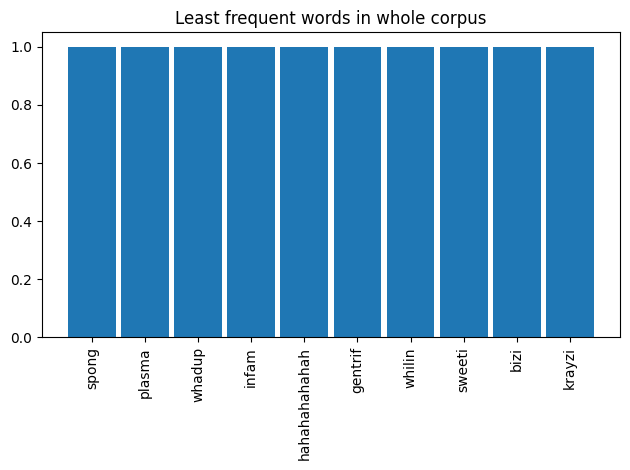

0            spong
1           plasma
2           whadup
3            infam
4    hahahahahahah
5          gentrif
6           whilin
7           sweeti
8             bizi
9           krayzi
Name: 0, dtype: object
number of words occurring once = 5547


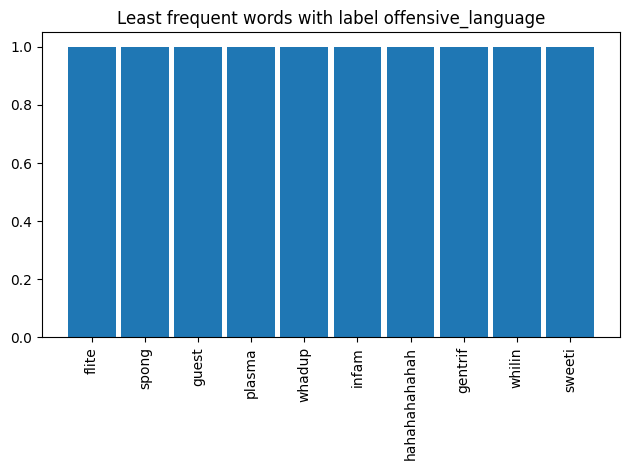

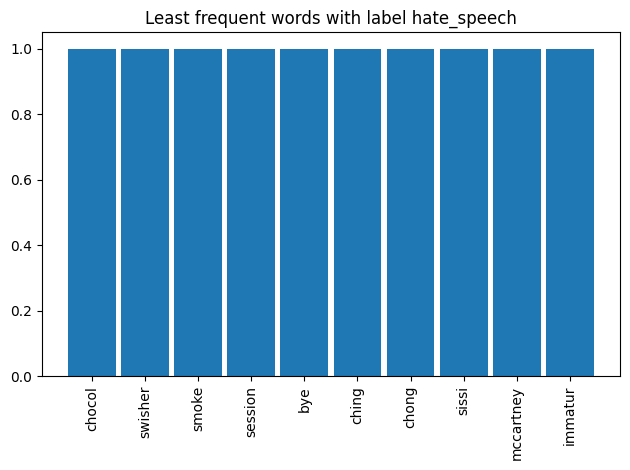

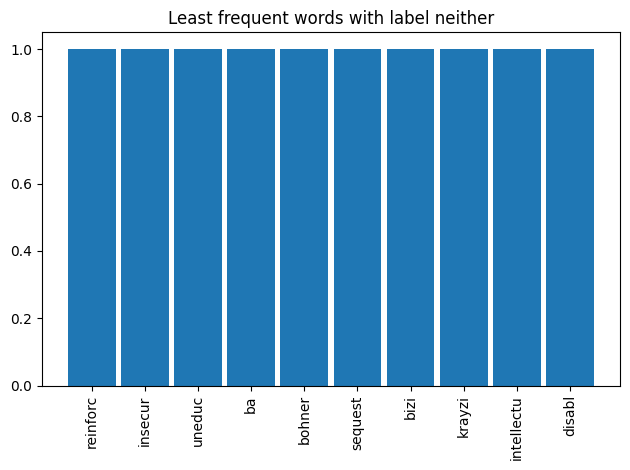

\begin{tabular}{llll}
\toprule
  Whole corpus & offensive\_language & hate\_speech &     neither \\
\midrule
         spong &              flite &      chocol &    reinforc \\
        plasma &              spong &     swisher &     insecur \\
        whadup &              guest &       smoke &      uneduc \\
         infam &             plasma &     session &          ba \\
 hahahahahahah &             whadup &         bye &      bohner \\
       gentrif &              infam &       ching &     sequest \\
        whilin &      hahahahahahah &       chong &        bizi \\
        sweeti &            gentrif &       sissi &      krayzi \\
          bizi &             whilin &   mccartney &  intellectu \\
        krayzi &             sweeti &     immatur &      disabl \\
\bottomrule
\end{tabular}



In [26]:
corpus = [str(l[1]) for l in data]
a=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]
PlotWordFreq(corpus, 'Least frequent words in whole corpus', 'least', 10)
print(pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0])

x = WordFreqCounter(corpus)
y = sum(value == 1 for value in x.values())
print("number of words occurring once = " + str(y))
### used the processed tweets ###

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[0]]
b=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[0]), 'least', 10)

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[1]]
c=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[1]), 'least', 10)

corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[2]]
d=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[2]), 'least', 10)

frames = [a, b, c, d]
df = pd.concat(frames, axis = 1)
df.columns = ["Whole corpus"]+train.get_labels()
print(df.to_latex(index=False))

In [128]:
corpus = [str(l[1]) for l in data]
a=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]


corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[0]]
b=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]


corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[1]]
c=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]


corpus = [str(l[1]) for l in data if l[3] == train.get_labels()[2]]
d=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]


frames = [a, b, c, d]
df = pd.concat(frames, axis = 1)
df.columns = ["Whole corpus"]+train.get_labels()
print(df.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Whole corpus & hate\_speech & offensive\_language & neither \\
\midrule
       b*tch &       b*tch &              b*tch &   trash \\
         hoe &      f*ggot &                hoe &    bird \\
        like &       n*gga &               like &    like \\
        f*ck &        f*ck &              p*ssi &     thi \\
       p*ssi &        like &               f*ck &  charli \\
         thi &      n*gger &              n*gga &  yellow \\
       n*gga &         ass &                thi &      go \\
         ass &       white &                ass &    make \\
        sh*t &         thi &               sh*t &   yanke \\
          go &       trash &                 go &    good \\
\bottomrule
\end{tabular}



In [129]:
str(data[0][1])

'make endear name like nigger spook amp monkey'

In [98]:
l = ('bitch', 'hoe', 'like', 'fuck', 'pussi', 'thi', 'nigga', 'ass', 'shit', 'go')
print(lazyCensorship(l))

('g', 'o')


In [111]:
def lazyCensorship(inputTuple):
    censorDict = {'bitch':'b*tch', 'fuck':'f*ck', 'pussi':'p*ssi', 'nigga':'n*gga', 'shit':'sh*t'}
    output = list()
    for element in inputTuple:
        print('here', element)
        if element in censorDict.keys():
            print('here', element, 3, censorDict[element])
            output.append(censorDict[element])
            print(output)
        else:
            output.append(element)
    return tuple(output)

In [112]:
print(lazyCensorship(l))


here bitch
here bitch 3 b*tch
['b*tch']
here hoe
here like
here fuck
here fuck 3 f*ck
['b*tch', 'hoe', 'like', 'f*ck']
here pussi
here pussi 3 p*ssi
['b*tch', 'hoe', 'like', 'f*ck', 'p*ssi']
here thi
here nigga
here nigga 3 n*gga
['b*tch', 'hoe', 'like', 'f*ck', 'p*ssi', 'thi', 'n*gga']
here ass
here shit
here shit 3 sh*t
['b*tch', 'hoe', 'like', 'f*ck', 'p*ssi', 'thi', 'n*gga', 'ass', 'sh*t']
here go
('b*tch', 'hoe', 'like', 'f*ck', 'p*ssi', 'thi', 'n*gga', 'ass', 'sh*t', 'go')
